In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Inspect tables to get column names
from sqlalchemy import inspect
inspector = inspect(engine)

# Measurement table columns
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Station table columns
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(query_date)

2016-08-23


In [13]:
# Perform a query to retrieve the data and precipitation scores
sel = [measurement.date, measurement.prcp]
prcp = session.query(*sel).filter(measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Droped NAs and set date column as index
prcp_df = pd.DataFrame(prcp, columns=['Date','Precipitaion'])
prcp_df = prcp_df.dropna(how='any')
prcp_df = prcp_df.set_index('Date')

# Sort the dataframe by date
prcp_df = prcp_df.sort_values('Date', ascending=True)
prcp_df.head()

,Precipitaion
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


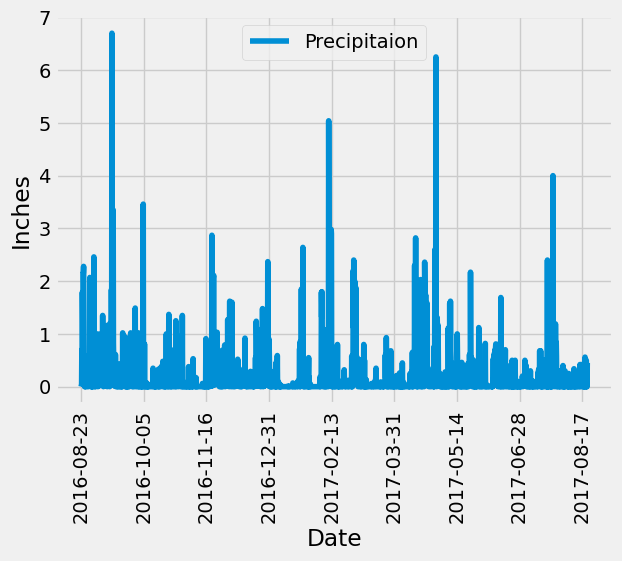

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(xlabel='Date', ylabel='Inches', rot=90)
plt.show()

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,Precipitaion
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number of stations in the dataset
session.query(station.id).count()

9

In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [measurement.station, func.count(measurement.id)]
active_stations = session.query(*sel).\
    group_by(measurement.station).\
    order_by(func.count(measurement.id).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)]
most_active_station = session.query(*sel).\
    group_by(measurement.station).\
    order_by(func.count(measurement.id).desc()).first()
most_active_station

(54.0, 85.0, 71.66378066378067)

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station
sel = [measurement.date, measurement.tobs]
station_temperatures = session.query(*sel).\
    filter(func.strftime(measurement.date) >= query_date, measurement.station == 'USC00519281').\
    group_by(measurement.date).\
    order_by(measurement.date).all()

# Save results as a DataFrame
station_temperatures_df = pd.DataFrame(station_temperatures, columns=['Date', 'Temperature'])
station_temperatures_df = station_temperatures_df.set_index('Date')
station_temperatures_df.head()

,Temperature
Date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0


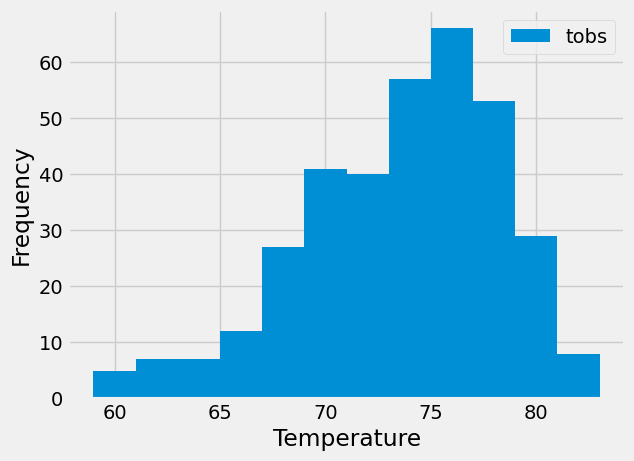

In [20]:
# plot the results as a histogram
plt.hist(station_temperatures_df['Temperature'], bins=12, density=False, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.show()


# Close Session

In [21]:
# Close Session
session.close()